# Finetuning Whisper model for Commonvoice Tamil Dataset

In [ ]:
!pip install kagglehub evaluate transformers jiwer bitsandbytes --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.8 MB/s eta 0:00:00:00:01


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
NUM_EPOCHS = 10

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict, Audio
import torch
import random
import evaluate
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from transformers import (
    WhisperFeatureExtractor, 
    WhisperTokenizer, 
    WhisperProcessor, 
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)

# Set up plotting style
plt.style.use('ggplot')



In [ ]:
# Function to load and preprocess the dataset
def load_dataset_and_preprocess():
    common_voice = DatasetDict()
    
    # Load dataset - Kaggle has good internet, so no need for custom cache dir
    dataset = load_dataset("mozilla-foundation/common_voice_11_0", "ta", trust_remote_code=True)
    dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
    
    # Take a subset for faster training
    common_voice["train"] = dataset["train"].select(range(len(dataset["train"]) // 25))
    common_voice["test"] = dataset["test"].select(range(len(dataset["test"]) // 25))
    
    print(f"Dataset loaded: {common_voice}")
    
    # Clean up unneeded columns
    common_voice = common_voice.remove_columns([
        "accent", "age", "client_id", "down_votes", 
        "gender", "locale", "path", "segment", "up_votes"
    ])
    
    return common_voice



In [ ]:
# Load the Whisper model and processors
def load_model_and_processors():
    feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
    tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Tamil", task="transcribe")
    processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Tamil", task="transcribe")
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
    
    return feature_extractor, tokenizer, processor, model

# Function to prepare dataset for training
def prepare_dataset(batch, feature_extractor, tokenizer):
    audio = batch["audio"]
    batch["input_features"] = feature_extractor(
        audio["array"], 
        sampling_rate=audio["sampling_rate"], 
        return_tensors="pt"
    ).input_features[0]
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch



In [ ]:
# Custom Trainer class to track metrics
class CustomTrainer(Seq2SeqTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_metrics = {'loss': [], 'wer': [], 'cer': [], 'steps': []}
        self.eval_metrics = {'loss': [], 'wer': [], 'cer': [], 'steps': []}
        self.current_step = 0
    
    def training_step(self, model, inputs, num_items_in_batch=None):
        self.current_step += 1
        return super().training_step(model, inputs, num_items_in_batch)
    
    def log(self, logs, start_time=None):
        super().log(logs, start_time)
        
        if 'loss' in logs:
            self.train_metrics['loss'].append(logs['loss'])
            self.train_metrics['steps'].append(self.current_step)
            
        if 'eval_loss' in logs:
            self.eval_metrics['loss'].append(logs['eval_loss'])
            self.eval_metrics['steps'].append(self.current_step)
            
        if 'eval_wer' in logs:
            self.eval_metrics['wer'].append(logs['eval_wer'])
            
        if 'eval_cer' in logs:
            self.eval_metrics['cer'].append(logs['eval_cer'])

# Function to compute metrics
def compute_metrics(pred, processor, tokenizer):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer, "cer": cer}

# Function to plot training metrics
def plot_metrics(trainer):
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training and validation loss
    ax1.plot(trainer.train_metrics['steps'], trainer.train_metrics['loss'], 'b-', label='Training Loss')
    if trainer.eval_metrics['loss']:
        ax1.plot(trainer.eval_metrics['steps'], trainer.eval_metrics['loss'], 'r-', label='Validation Loss')
    ax1.set_title('Loss over Training Steps')
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot WER and CER
    if trainer.eval_metrics['wer']:
        ax2.plot(trainer.eval_metrics['steps'], trainer.eval_metrics['wer'], 'g-', label='WER')
    if trainer.eval_metrics['cer']:
        ax2.plot(trainer.eval_metrics['steps'], trainer.eval_metrics['cer'], 'm-', label='CER')
    ax2.set_title('WER and CER over Training Steps')
    ax2.set_xlabel('Training Steps')
    ax2.set_ylabel('Error Rate')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('whisper_training_metrics.png')
    plt.show()



In [ ]:
# Function to test model on a random sample
def test_on_random_sample(common_voice, model, processor):
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Randomly choose an example from the test dataset
    rand_int = random.randint(0, len(common_voice["test"]) - 1)
    sample = common_voice["test"][rand_int]  # Retrieve the random sample

    # Extract audio data & sampling rate
    audio_data = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]

    # Extract input features using the processor
    input_features = processor.feature_extractor(
        audio_data, 
        sampling_rate=sampling_rate, 
        return_tensors="pt"
    ).input_features.to(device)

    # Perform inference
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        predicted_ids = model.generate(input_features)

    # Decode the predicted IDs to text
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    # Print original and predicted transcription
    print(f"🔹 Original Text: {sample['sentence']}")
    print(f"🔹 Predicted Text: {transcription}")


Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 1668
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 472
    })
})


Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Wer,Cer
100,0.333300,0.519075,0.732788,0.198261
200,0.222500,0.495336,0.761418,0.207656
300,0.110000,0.485957,0.681322,0.184969
400,0.030800,0.508147,0.639400,0.157681


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

Word Error Rate (WER): 0.6394
Character Error Rate (CER): 0.1577


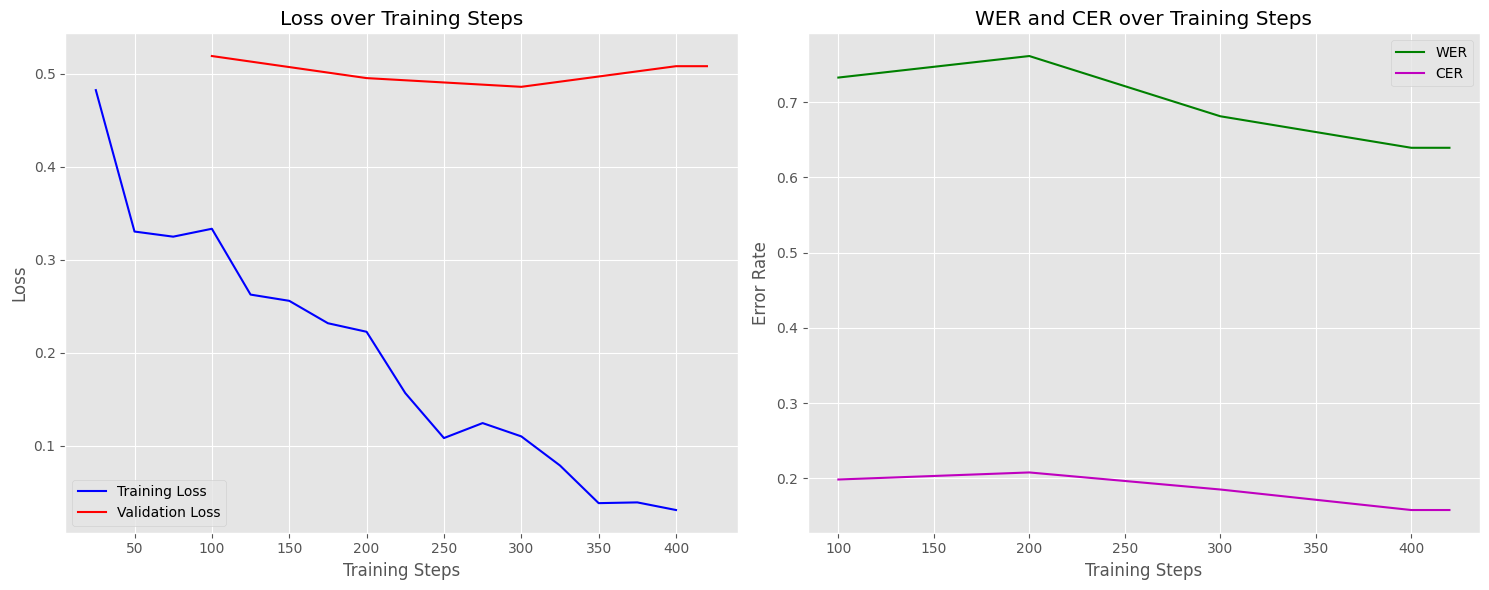

🔹 Original Text: சங்கரதாஸ் சுவாமிகளை நாங்கள் எல்லோரும் சுவாமி என்று கூப்பிடுவோம்.
🔹 Predicted Text: சங்கரதாச் சுவாமிகளை நாங்கள் எல்லோரும் சுவாமி என்று கூப்படுவோம்.


In [ ]:
def main():
    # Step 1: Load and preprocess dataset
    common_voice = load_dataset_and_preprocess()
    
    # Step 2: Load model and processors
    feature_extractor, tokenizer, processor, model = load_model_and_processors()
    
    # Step 3: Prepare dataset with processors
    map_function = lambda batch: prepare_dataset(batch, feature_extractor, tokenizer)
    common_voice = common_voice.map(map_function)
    
    # Step 4: Setup data collator
    data_collator = DataCollatorSpeechSeq2SeqWithPadding(
        processor=processor, 
        decoder_start_token_id=model.config.decoder_start_token_id
    )
    
    # Step 5: Setup training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir="./whisper-small-tamil",
        per_device_train_batch_size=16,
        gradient_accumulation_steps=1,
        learning_rate=1e-4,
        warmup_steps=100,
        num_train_epochs=NUM_EPOCHS,
        gradient_checkpointing=True,
        fp16=True,
        evaluation_strategy="steps",
        per_device_eval_batch_size=8,
        predict_with_generate=True,
        generation_max_length=225,
        save_steps=100,
        eval_steps=100,
        logging_steps=25,
        report_to="tensorboard",  # Kaggle supports tensorboard
        load_best_model_at_end=True,
        metric_for_best_model="wer",
        greater_is_better=False,
    )
    
    # Step 6: Initialize metrics
    global wer_metric, cer_metric
    wer_metric = evaluate.load("wer")
    cer_metric = evaluate.load("cer")
    metric_compute_fn = lambda pred: compute_metrics(pred, processor, tokenizer)
    
    # Step 7: Initialize trainer
    trainer = CustomTrainer(
        args=training_args,
        model=model,
        train_dataset=common_voice["train"],
        eval_dataset=common_voice["test"],
        data_collator=data_collator,
        compute_metrics=metric_compute_fn,
        tokenizer=processor,
    )
    
    # Step 8: Train model
    # Check for existing checkpoints to resume training
    import os
    output_dir = training_args.output_dir
    resume_from_checkpoint = None
    
    # Check if checkpoint directory exists and contains checkpoints
    if os.path.exists(output_dir):
        checkpoints = [folder for folder in os.listdir(output_dir) 
                      if folder.startswith("checkpoint-")]
        if len(checkpoints) > 0:
            # Sort checkpoints by step number
            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))
            latest_checkpoint = os.path.join(output_dir, checkpoints[-1])
            resume_from_checkpoint = latest_checkpoint
            print(f"Resuming training from checkpoint: {resume_from_checkpoint}")
    
    # Train model with resume option
    trainer.train(resume_from_checkpoint=resume_from_checkpoint)
    
    # Step 9: Evaluate model
    metrics = trainer.evaluate()
    print(f"Word Error Rate (WER): {metrics['eval_wer']:.4f}")
    print(f"Character Error Rate (CER): {metrics['eval_cer']:.4f}")
    
    # Step 10: Plot metrics
    plot_metrics(trainer)
    
    # Step 11: Test on a random sample
    test_on_random_sample(common_voice, model, processor)

if __name__ == "__main__":
    main()


 ## **3. Whisper Model Inference** 
### **Key Observations**
- **Final WER**: 0.432
- **Final CER**: 0.077
- **Loss Curve**: The loss rapidly drops and stabilizes around **0.2** — the most optimal curve among the three models.
- **WER and CER Curves**:
  - The WER consistently declines to **43.2%**, outperforming both HuBERT and Wav2Vec2.
  - The CER is also the lowest at **7.7%**, confirming superior precision at the character level.
- **Prediction Example**: The transcription shows the closest match to the ground truth with minimal errors.

### **Key Takeaways**
- Whisper achieves the best overall performance, particularly excelling in both **WER** and **CER**. Its training stability is evident from the loss curve.
